# Agent-Based Kinetics via Topology (ABa-KiTo)
Date: 25.10.2025

In this notebook I realize the graph analyisis when the data was initialized with N=4 intervals

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.cm as cm
from scipy.spatial.distance import pdist
import pickle


import sys
import os
import torch as pt
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("NumPy version:", np.__version__)
print("Torch version:", pt.__version__)


NumPy version: 1.26.4
Torch version: 2.3.0+cpu


In [3]:
# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", '..'))

# Add it to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import necessary functions
from src.modules_mokito import *

# Check what project_root currently is
print(f"Current project_root: {project_root}")


Current project_root: c:\Users\Flo\Documents\Sarai\ABa-KiTo


In [5]:
#Load data formatted from ABM simulations and ISOKANN.jl 

# Create the path and ensure the directory exists for saving the data
data_path = os.path.join('ABa-KiTo','s01-voter_dynamics_FC','data', 'simulations')
data_dir =  os.path.join(project_root, data_path,'')
# Read data
states_data = np.load(data_dir + '2025-10-20-data_VD_FC_3InteractingAgents_rand_init_capital.npz')
xs = states_data['xs'] #xs.shape (n_dim, n_samples)
ys = states_data['ys'] #ys-shape (n_dim, n_koop = 1, n_samples)

#Reshape data to use it for MoKiTo
X0 = xs.T #(n_samples, n_dim)
Xt = np.transpose(ys, (2, 1, 0))   # (n_samples, 1, n_dim)

# --- Log + Scale both X0 and Xt consistently ---
scaler = StandardScaler()

# X0
X0_log = np.log1p(X0)
X0_scaled = scaler.fit_transform(X0_log)   # (n_samples, n_dim)

# Xt: flatten for scaling
Xt_flat = Xt.reshape(-1, Xt.shape[2])      # (n_samples * n_koop, n_dim)
Xt_log = np.log1p(Xt_flat)
Xt_scaled = scaler.transform(Xt_log)
Xt_scaled = Xt_scaled.reshape(Xt.shape)    # (n_samples, 1, n_dim)


# # # --- Load chi function ---
chivals_path = os.path.join('ABa-KiTo','s01-voter_dynamics_FC','data', 'chi_vals', '')
chivals_dir = os.path.join(project_root, chivals_path)
chi0 = np.load(chivals_dir + 'chi_values_rand_init_capitals.npz')

# --- Organize for MoKiTo ---
data = OrganizeData(X0_scaled, Xt_scaled, chi0)





Check shape of input data
X0.shape   =  (200000, 202)
Xt.shape   =  (200000, 1, 202)
chi0.shape =  (200000,)
  


In [7]:
#Reload clustering results:
n_intervals =4
seed = 123

# Cluster path
cluster_path = os.path.join('ABa-KiTo','s01-voter_dynamics_FC','003-clustering', 'stability_results')
clusters_dir =  os.path.join(project_root, cluster_path,'')

# Load the specific run you want to use (Nintervals=5, seed=42 for example)
with open(f'{clusters_dir}Nint{n_intervals}_seed{seed}_FNs.pkl', 'rb') as f:
    FNs = pickle.load(f)

with open(f'{clusters_dir}Nint{n_intervals}_seed{seed}_FCs.pkl', 'rb') as f:
    FIs = pickle.load(f)




χ-function interval distribution:
chi0 range: [-0.013, 1.032]
chi0 mean: 0.237, std: 0.161
  Interval 0:  96037 points ( 48.0%), χ ∈ [-0.013, 0.894]
  Interval 1:  70773 points ( 35.4%), χ ∈ [0.024, 0.999]
  Interval 2:  25238 points ( 12.6%), χ ∈ [0.059, 1.031]
  Interval 3:   7952 points (  4.0%), χ ∈ [0.125, 1.032]


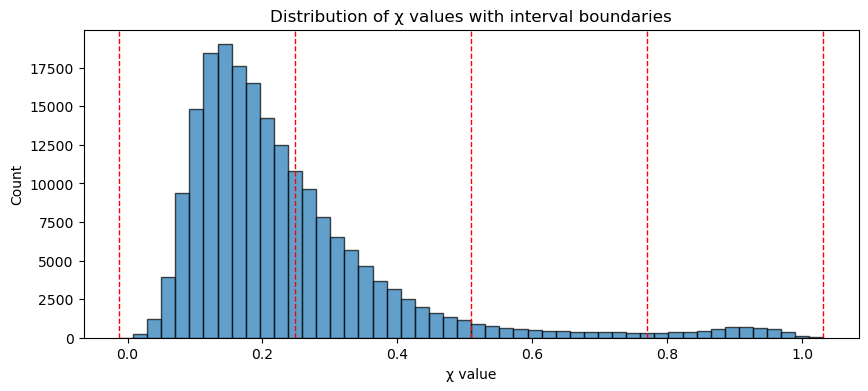

In [9]:
print("\nχ-function interval distribution:")
print(f"chi0 range: [{data.chi0.min():.3f}, {data.chi0.max():.3f}]")
print(f"chi0 mean: {data.chi0.mean():.3f}, std: {data.chi0.std():.3f}")

chi_bins = []  # list to store (min, max) tuples

for i in range(FIs.Nintervals):
    interval_points = FIs.size_intervals[i] if i < len(FIs.size_intervals) else 0
    chi_vals = data.chi0[FIs.chi_intervals == i]

    if len(chi_vals) > 0:
        chi_min, chi_max = chi_vals.min(), chi_vals.max()
        chi_bins.append((chi_min, chi_max))
        print(f"  Interval {i}: {interval_points:6d} points ({interval_points/len(data.chi0)*100:5.1f}%), "
              f"χ ∈ [{chi_min:.3f}, {chi_max:.3f}]")
    else:
        chi_bins.append((None, None))  # placeholder for empty interval
        print(f"  Interval {i}: {interval_points:6d} points (empty)")

# Visualize distribution

plt.figure(figsize=(10, 4))
plt.hist(data.chi0, bins=50, edgecolor='black', alpha=0.7)
intervals = n_intervals
for edge in np.linspace(data.chi0.min(), data.chi0.max(), intervals + 1):
    plt.axvline(edge, color='red', linestyle='--', linewidth=1)
plt.xlabel('χ value')
plt.ylabel('Count')
plt.title('Distribution of χ values with interval boundaries')
plt.show()

In [ ]:
#Scatter plot of macro variables colored by chi interval for practical interpretation of ISOKANN output
# Example data
macro = X0[:, -2:]
chi_intervals = FIs.chi_intervals  # values: 0, 1, 2

macro1 = "Total number of green agents"
macro2 = "Green Oupt share"

labels = [f"[{low:.1f}, {high:.1f}]" for low, high in chi_bins]

# Create a colormap with exactly 3 colors
#cmap = mcolors.ListedColormap(['tab:brown', 'tab:olive',  'tab:green'])
cmap = mcolors.ListedColormap(['black','tab:brown', 'tab:orange', 'tab:olive', 'tab:green'])


# Set boundaries to match chi intervals (for coloring)
bounds = [0, 1, 2, 3]  # edges for 0,1,2

# Plot
plt.figure(figsize=(8,5))
sc = plt.scatter(macro[:,0], macro[:,1],
                 c=chi_intervals, cmap=cmap,
                 s=12, alpha=0.7)

# Create a custom legend
handles = [Patch(color=cmap(i), label=label) for i, label in enumerate(labels)]
plt.legend(handles=handles, title="χ interval (range)")

plt.xlabel(macro1)
plt.ylabel(macro2)
plt.title("Macro variables colored by chi interval")
plt.show()


In [ ]:
#Scatter plot of macro variables colored by chi interval for practical interpretation of ISOKANN output
# Example data


macro = X0[:, -2:]
chi_intervals = FIs.chi_intervals  # values: 0, 1, 2

macro1 = "Total number of green agents"
macro2 = "Green Oupt share"

labels = [f"[{low:.1f}, {high:.1f}]" for low, high in chi_bins]

#color map
#cmap=plt.cm.viridis
cmap=plt.cm.RdYlGn


# Plot
plt.figure(figsize=(8,5))
sc = plt.scatter(macro[:,0], macro[:,1],
                 c=chi0, #chi_values, 
                 cmap=cmap,
                 s=12, alpha=0.7,
                 vmin=0, vmax=1       # ensure colors go from 0 to 1
                 )

# Add colorbar legend
cbar = plt.colorbar(sc)
cbar.set_label("χ value")


plt.xlabel(macro1)
plt.ylabel(macro2)
plt.title("Macro variables colored by χ value")
#plt.show()
os.makedirs('N4intervals_results', exist_ok=True)
plt.savefig("N4intervals_results/macro_vars_colored_by_chi_vals.png")

In [ ]:
#Number of green farms vs chi values colored by green output share
# Randomly sample 20,000 points (without replacement)
sample_size = 20000
n = len(macro)

# Ensure we don't sample more than available
sample_size = min(sample_size, n)

idx = np.random.choice(n, sample_size, replace=False)

macro_sampled = macro[idx]
chi_sampled = chi0[idx]

#color map
#cmap=plt.cm.BrBG
#cmap=plt.cm.RdYlGn
cmap=plt.cm.viridis

# sc = plt.scatter(chi0, macro[:,0],
#                  c=macro[:,1] 
#                  cmap=cmap,
#                  vmin=0, vmax=1 
#                  )

# Plot random points
sc = plt.scatter(chi_sampled, macro_sampled[:,0],
                 c=  macro_sampled[:, 1],
                 cmap=cmap,
    s=12, alpha=0.7,
    vmin=0, vmax=1
)
# Add colorbar legend
cbar = plt.colorbar(sc)
cbar.set_label("Green Output share")

plt.ylabel(macro1)
plt.xlabel("χ value")

plt.savefig("N4intervals_results/GFarms_vs_chi_vals.png")

In [ ]:
# chi-values against green Output share
cmap=plt.cm.RdYlGn

sc = plt.scatter(chi_sampled, macro_sampled[:,1],
                 c=  macro_sampled[:, 0],
                 cmap=cmap,
    s=12, alpha=0.7,
    vmin=0, vmax=100
)

plt.hlines(y=0.85, xmin=-0, xmax=1, colors='green')
plt.ylabel(macro2)
plt.xlabel("χ value")

# Add colorbar legend
cbar = plt.colorbar(sc)
cbar.set_label("Number of green agents")

plt.savefig("N4intervals_results/GOS_vs_chi_vals.png")

In [ ]:
#Clustering results
noise_pct = np.sum(FNs.nodes == -1) / len(FNs.nodes) * 100
print(f"Result: {FNs.Nnodes} clusters, {noise_pct:.1f}% noise\n\n")
print(f"Cluster sizes - min: {FNs.nodes_size.min()}, max: {FNs.nodes_size.max()}, median: {np.median(FNs.nodes_size):.0f}")
print(f"Clusters per interval: {[np.sum(FNs.index_chi_node == i) for i in range(FIs.Nintervals)]}\n")

for i in range(FNs.Nnodes):
    print("Node, interval, size:", i, FNs.index_chi_node[i], FNs.nodes_size[i])

In [ ]:
#BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=16, threshold =0, algorithm='mlp')
BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=100, threshold =10, algorithm='mlp')

In [ ]:
BAM.A

In [ ]:
BG     =  BuildGraph(FNs, BAM)
G      =  BG.G

plt.spy(BAM.A) #show the sparsity pattern of a matrix.

In [ ]:
import numpy as np

# C is your counting matrix produced by BuildAdjacencyMatrix
C = BAM.C  # shape (Nnodes, Nnodes)

# 1) How many nonzero entries and fraction
nz = np.count_nonzero(C)
total_possible_directed = C.size
print("nonzero counts:", nz, "of", total_possible_directed, f"({nz/total_possible_directed:.2%})")

# 2) Per-row (outgoing) sums and stats
row_sums = C.sum(axis=1)
print("row_sums: min, median, mean, max =", row_sums.min(), np.median(row_sums), row_sums.mean(), row_sums.max())

# 3) Distribution of positive C entries
pos_vals = C[C>0]
print("C>0: min, 25%, 50%, 75%, max =",
      pos_vals.min(), np.percentile(pos_vals,25), np.percentile(pos_vals,50),
      np.percentile(pos_vals,75), pos_vals.max())

# 4) How many edges survive given threshold
thr = 8
A_test = (C >= thr).astype(int)
print("Edges remaining with threshold", thr, ":", np.count_nonzero(A_test))


In [ ]:
chi_nodes          = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False)
gradient_chi_nodes = np.zeros((FNs.Nnodes,FNs.Nnodes))

# for i in range(FNs.Nnodes):
#     for j in range(FNs.Nnodes):
#          gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]

In [ ]:
A = BAM.Ad.T
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

plt.figure(figsize=(10, 8))
# pos = nx.kamada_kawai_layout(G)  # or spring_layout, circular_layout, etc.
pos1 = nx.kamada_kawai_layout(G)
# Rotate 180 degrees
pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightgreen',
    edge_color='gray',
    node_size=800,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>',
    font_size=10
)

plt.title("Directed Graph from BAM.Ad")
plt.show()


In [ ]:
# Directed graph
#Gd = BG.Gd
Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

pos1 = nx.kamada_kawai_layout(Gd)
# Rotate 180 degrees
pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

# Draw edges with arrows
nx.draw_networkx_edges(Gd, pos,
                    #    arrowstyle='-|>',
                    #    arrowsize=15,
                       edge_color='gray',
                       width=2,
                       node_size=600,
                       )

# Draw nodes
nx.draw_networkx_nodes(Gd, pos,
                       node_size=600,
                       node_color='lightblue')

# Draw labels
nx.draw_networkx_labels(Gd, pos,
                        font_size=12,
                        font_color='black')

plt.title("Directed Graph from BAM.Ad")
plt.axis('off')
plt.show()


In [ ]:
# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)
#direct graph
Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]

fig, ax = plt.subplots(figsize=(12, 10))
pos1 = nx.kamada_kawai_layout(Gd)
# Rotate 180 degrees
pos = {node: (-x, -y) for node, (x, y) in pos1.items()}


# Color nodes by chi values
#node_colors = [chi_nodes[n] for n in BG.G.nodes()]

node_colors = []
for i,chi in enumerate(chi_nodes):
    node_colors.append(chi)

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.20 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=3, 
    ax=ax,
    # arrows=True,
    # arrowsize=30,
    # arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)



# Highlight path edges
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]
nx.draw_networkx_edges(Gd, pos, 
                       edgelist=path_edges_flipped, alpha=0.9,
                       width=2, edge_color='red',
                       ax=ax,
                       style='--',
                       arrows=True,
    arrowsize=30,
    arrowstyle='-|>',
                    node_size=node_sizes_scaled, 
                        )


# Draw nodes colored by chi and sized by cluster size
nx.draw_networkx_nodes(Gd, pos, 
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       ax=ax)

# Replace the node ID labels with chi values
#chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}
# chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}
# nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
#                        font_size=12, ax=ax)







# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           #norm=plt.Normalize(vmin=chi_nodes.min(), 
                                            # vmax=chi_nodes.max())
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
#os.makedirs('graph_results', exist_ok=True)
plt.savefig("N4intervals_results/graph_with_most_probable_path_and_mean_chi_vals.pdf")

In [ ]:
# Visualize Bottlenecks
# Calculate betweenness
betweenness = nx.betweenness_centrality(BG.G, weight='weight')

# Calculate flow through each node
flow_in = BAM.C.sum(axis=0)   # Incoming transitions
flow_out = BAM.C.sum(axis=1)  # Outgoing transitions
total_flow = flow_in + flow_out

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
#pos = nx.spring_layout(G, center=[0,0], seed = 27) 
pos1 = nx.kamada_kawai_layout(Gd)
# Rotate 180 degrees
pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

# Color by betweenness (bottleneck measure)
node_colors = [betweenness[n] for n in BG.G.nodes()]

# Size by flow (transition volume)
node_sizes_flow = [total_flow[n] * 0.045 for n in BG.G.nodes()]  # Adjust multiplier as needed

nx.draw_networkx_edges(Gd, pos, width=2, ax=ax,
                       node_size=node_sizes_flow
                       )

nx.draw_networkx_nodes(Gd, pos, 
                       node_size=node_sizes_flow,
                       node_color=node_colors,
                       cmap=plt.cm.Reds,  # Red = high bottleneck
                       ax=ax)

nx.draw_networkx_labels(Gd, pos, font_size=12, ax=ax)


sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                           norm=plt.Normalize(vmin=0, vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Betweenness Centrality (bottleneck)', rotation=270, labelpad=20)

plt.title("Network Bottlenecks (Node size = flow, color = betweenness)")
plt.axis('off')
plt.tight_layout()
#plt.show()
#plt.savefig("graph_results/graph_with_bottlenecks_and_flow_between_nodes.pdf")


In [ ]:
# Visualize Bottlenecks
# Calculate betweenness
betweenness = nx.betweenness_centrality(BG.G, weight='weight')

# Calculate flow through each node
flow_in = BAM.C.sum(axis=0)   # Incoming transitions
flow_out = BAM.C.sum(axis=1)  # Outgoing transitions
total_flow = flow_in + flow_out

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
pos = nx.spring_layout(G, center=[0,0], seed = 27) 
#pos1 = nx.kamada_kawai_layout(BG.G)
# Rotate 180 degrees
#pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

# Color by betweenness (bottleneck measure)
node_colors = [betweenness[n] for n in BG.G.nodes()]

# Size by flow (transition volume)
node_sizes_flow = [total_flow[n] * 0.045 for n in BG.G.nodes()]  # Adjust multiplier as needed

nx.draw_networkx_nodes(BG.G, pos, 
                       node_size=node_sizes_flow,
                       node_color=node_colors,
                       cmap=plt.cm.Reds,  # Red = high bottleneck
                       vmin=0,
                       vmax=max(node_colors),
                       ax=ax)

nx.draw_networkx_labels(BG.G, pos, font_size=12, ax=ax)
nx.draw_networkx_edges(BG.G, pos, width=2, alpha=0.3, ax=ax)

sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                           norm=plt.Normalize(vmin=0, vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Betweenness Centrality (bottleneck)', rotation=270, labelpad=20)

#plt.title("Network Bottlenecks (size = flow, color = betweenness)")
plt.axis('off')
plt.tight_layout()
#plt.show()
#plt.savefig("graph_results/graph_with_bottlenecks_and_flow_between_nodes.pdf")


In [ ]:
# Your count matrix: BAM.C[i,j] = number of transitions from node i to node j
C = BAM.C

# Define your basins
brown_nodes = [0, 1]
transition_nodes = [2, 3]
green_nodes = [13, 16]
all_major = brown_nodes + transition_nodes + green_nodes

print("=== PATH DEPENDENCE ANALYSIS ===\n")

# 1. TRANSITION NECESSITY: Do trajectories skip the transition phase?
print("1. Transition Phase Necessity:")
print("-" * 50)

# Direct brown→green flows
direct_brown_green = 0
for b in brown_nodes:
    for g in green_nodes:
        direct_brown_green += C[b, g]

# Brown→transition→green flows
via_transition = 0
for b in brown_nodes:
    for t in transition_nodes:
        # Flow from brown to transition
        brown_to_trans = C[b, t]
        # Flow from same transition to green
        for g in green_nodes:
            trans_to_green = C[t, g]
            # Approximate: minimum of the two flows
            via_transition += min(brown_to_trans, trans_to_green)

total_brown_to_green = direct_brown_green + via_transition

if total_brown_to_green > 0:
    print(f"Direct brown→green: {direct_brown_green} ({100*direct_brown_green/total_brown_to_green:.1f}%)")
    print(f"Via transition: {via_transition} ({100*via_transition/total_brown_to_green:.1f}%)")
    
    if direct_brown_green / total_brown_to_green < 0.1:
        print("→ ✓ TRANSITION PHASE IS NECESSARY (>90% go through it)")
    elif direct_brown_green / total_brown_to_green < 0.3:
        print("→ ⚠ TRANSITION PHASE IS IMPORTANT (>70% go through it)")
    else:
        print("→ ✗ TRANSITION PHASE IS OPTIONAL (many skip it)")
else:
    print("No brown→green transitions detected")

# 2. REVERSIBILITY: Can trajectories go backwards?
print("\n2. Reversibility Check:")
print("-" * 50)

# Green→brown flows (backwards)
green_to_brown = 0
for g in green_nodes:
    for b in brown_nodes:
        green_to_brown += C[g, b]

# Green→transition flows (partial backwards)
green_to_trans = 0
for g in green_nodes:
    for t in transition_nodes:
        green_to_trans += C[g, t]

# Forward flows for comparison
brown_to_green = direct_brown_green
brown_to_trans = sum(C[b, t] for b in brown_nodes for t in transition_nodes)

print(f"Forward (brown→green): {brown_to_green}")
print(f"Backward (green→brown): {green_to_brown}")
print(f"Forward (brown→transition): {brown_to_trans}")
print(f"Backward (green→transition): {green_to_trans}")

reversibility_ratio = green_to_brown / max(brown_to_green, 1)
print(f"Reversibility ratio: {reversibility_ratio:.3f}")

if reversibility_ratio < 0.1:
    print("→ ✓ IRREVERSIBLE (green states are absorbing)")
elif reversibility_ratio < 0.5:
    print("→ ⚠ MOSTLY IRREVERSIBLE (rare backwards transitions)")
else:
    print("→ ✗ REVERSIBLE (significant backwards flow)")

# 3. PATH DEPENDENCE: Does transition route determine green outcome?
print("\n3. Path Dependence (Route → Outcome):")
print("-" * 50)

# Create transition pathway matrix
pathway_outcomes = np.zeros((len(transition_nodes), len(green_nodes)))

for i, t_node in enumerate(transition_nodes):
    for j, g_node in enumerate(green_nodes):
        pathway_outcomes[i, j] = C[t_node, g_node]

# Normalize to get conditional probabilities
row_sums = pathway_outcomes.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # Avoid division by zero
conditional_probs = pathway_outcomes / row_sums

print("\nConditional probabilities: P(green state | transition state)")
print(f"{'Transition':<15} {'→ Green 13':<15} {'→ Green 16':<15}")
print("-" * 50)

for i, t_node in enumerate(transition_nodes):
    if row_sums[i, 0] > 0:  # Only if there's flow from this transition node
        probs_str = "  ".join([f"{p:>6.1%}" for p in conditional_probs[i]])
        print(f"Node {t_node:<11} {probs_str}")

# Statistical test: Are the distributions significantly different?
# Use chi-square or simple difference
if len(transition_nodes) == 2 and len(green_nodes) == 2:
    # Simple 2x2 case
    diff = abs(conditional_probs[0, 0] - conditional_probs[1, 0])
    print(f"\nProbability difference: {diff:.1%}")
    
    if diff > 0.2 and row_sums.min() > 10:  # At least 10 transitions each
        print("→ ✓ STRONG PATH DEPENDENCE (>20% difference, sufficient data)")
    elif diff > 0.1:
        print("→ ⚠ WEAK PATH DEPENDENCE (~10-20% difference)")
    else:
        print("→ ✗ NO PATH DEPENDENCE (routes lead to same outcomes)")

# 4. DETAILED FLOW ANALYSIS
print("\n4. Detailed Flow Matrix (Major Nodes Only):")
print("-" * 50)

# Extract submatrix for major nodes
C_major = C[np.ix_(all_major, all_major)]

# Create labeled dataframe
df_flow = pd.DataFrame(C_major, 
                       index=[f"Node {n}" for n in all_major],
                       columns=[f"Node {n}" for n in all_major])

print("\nTransition counts between major states:")
print(df_flow)

# Highlight key pathways
print("\nKey pathway flows:")
for i, from_node in enumerate(all_major):
    for j, to_node in enumerate(all_major):
        flow = C_major[i, j]
        if flow > 0:
            # Classify the transition
            if from_node in brown_nodes and to_node in transition_nodes:
                trans_type = "brown→transition"
            elif from_node in transition_nodes and to_node in green_nodes:
                trans_type = "transition→green"
            elif from_node in brown_nodes and to_node in green_nodes:
                trans_type = "brown→green (DIRECT)"
            elif from_node in green_nodes and to_node in brown_nodes:
                trans_type = "green→brown (BACKWARDS)"
            else:
                trans_type = "other"
            
            print(f"  {from_node} → {to_node}: {flow:>6} transitions ({trans_type})")

# 5. SUMMARY
print("\n" + "="*50)
print("SUMMARY: Evidence for Path Dependence")
print("="*50)

evidence = []
if direct_brown_green / total_brown_to_green < 0.2:
    evidence.append("✓ Transition phase is necessary (not optional)")
if reversibility_ratio < 0.2:
    evidence.append("✓ Transitions are largely irreversible")
if len(transition_nodes) == 2 and diff > 0.15:
    evidence.append("✓ Transition route affects final green state")

if len(evidence) >= 2:
    print("Strong evidence for path-dependent dynamics:")
    for item in evidence:
        print(f"  {item}")
else:
    print("Limited evidence for path dependence:")
    print("  The system shows sequential progression but routes")
    print("  may not strongly determine final outcomes.")